# <CENTER>**`VII.` MODEL SELECTION - Property Pricing Model**<CENTER>
----

In [55]:
## Importing all necessary tools:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

from sklearn.base import BaseEstimator, TransformerMixin         ## for creating Custom Transformer Class...
from sklearn.pipeline import Pipeline                            ## for creating ML Pipeline...
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder  ## for Categorical Encoding...

from sklearn.preprocessing import StandardScaler                 ## for Scaling of Numerical Features... 
from sklearn.compose import ColumnTransformer                    ## for pairing all feature transformers together...

from sklearn.model_selection import KFold, cross_val_score       ## for Cross-Validation...
from sklearn.model_selection import train_test_split             ## for splitting data...

## ML Models:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score, max_error   ## for Scoring Models...

import optuna                                                          ## Library for Bayesian Optimization...

import warnings
warnings.filterwarnings("ignore")        ## Hides all warnings

In [57]:
## Loading CSV File:
df = pd.read_csv('Gurgaon_Real_Estate_Final.csv', index_col = 'Unnamed: 0')
df.head(3)

,Flat,Sector_Locality,Locality,Built_up_area_in_sqft,Age_Category,Floor_Category,Building_Height_Category,Furnishing,Price_in_rupees,Avg_price_rupee_per_sqft,Bedrooms,Bathrooms,Covered_parking,Open_parking,Balcony,Sector_Amenity_Score
0,2 BHK Flat,Sector 86,New Gurugram,593,Newer Property,Upper Floor,Shorter Building,Semi Furnished,6800000,11470.0,2,2,0,1,1,2.0
1,2 BHK Flat,Sector 86,New Gurugram,690,Newer Property,Lower Floor,Medium Building,Unfurnished,6300000,9130.0,2,2,0,0,1,2.0
2,2 BHK Flat,Sector 108,Dwarka Expressway Belt,1000,Newer Property,Middle Floor,Taller Building,Semi Furnished,15000000,15000.0,2,2,1,1,3,0.0


<br><br><br>

---
## **`Transforming Target and Key Input Features and Splitting data :`**

In [59]:
## Transforming "Built-ip Area" & "Price" Feature:
df['Price_in_rupees'] = np.log1p(df['Price_in_rupees'])
df['Built_up_area_in_sqft'] = np.log1p(df['Built_up_area_in_sqft'])

X = df.drop(columns = ['Price_in_rupees'])
Y = df['Price_in_rupees']

## Splitting Data into Train-Test Sets:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.21125)

In [60]:
print("Dimension of each set: ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Dimension of each set:  (5595, 15) (1499, 15) (5595,) (1499,)


---

<br><br>
# **`I. Building Training Pipeline :`**
- The Pipeline will consist of 2 steps:
    1. Feature Transformation
    2. Model Training
 
#### **Creating Custom Transformer Class - "Sector_Locality_PD_Adder":**
- This transformation will add a new feature to the DF - **"Historical Median Price Density of Sector_Locality"**.
- **`REASON :`** Property Price would lead to Data Leakage. But historical Price Density records if used properly won't lead to Data Leakage and instead help Model to learn better. 

In [63]:
## Custom Transformer Class for Adding new feature to Data:
class Sector_Locality_PD_Adder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.PD_records = None

    def fit(self, X, y=None):
        X = X.copy()   
        ## We are creating Historical Median Price Density Records from Property data: 
        self.PD_records = X.groupby(by = 'Sector_Locality').agg({'Avg_price_rupee_per_sqft': 'median'
                                                                  }).to_dict()['Avg_price_rupee_per_sqft']
        return self

    def transform(self, X):
        X = X.copy()   
        values = X['Sector_Locality'].replace(self.PD_records)   ## Using saved records...

        ## Creating a new feature with name "Sector_Locality_Price_Density" in X:
        X.insert(4, "Sector_Locality_Price_Density", values, allow_duplicates = False)
        
        ## Removing "Avg_price_rupee_per_sqft" from X as it can potentially cause Data Leakage:
        X = X[['Flat', 'Sector_Locality', 'Locality', 'Built_up_area_in_sqft', 'Sector_Locality_Price_Density', 
               'Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing', 'Bedrooms', 'Bathrooms', 
               'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score']]
        
        return X


    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)


<br>

### **Defining the Feature Transformations and Pipeline :** 
- Training a Linear Regression Model to check the Pipeline and training setup.

In [73]:
## Preprocessor with only Label Encoding for Categorical Features:
Preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Sector_Locality_Price_Density', 'Bedrooms', 'Bathrooms', 'Covered_parking', 
                                   'Open_parking', 'Balcony', 'Sector_Amenity_Score']),
        ('cat', OrdinalEncoder(), ['Flat', 'Sector_Locality', 'Locality', 'Age_Category', 'Floor_Category', 
                                   'Building_Height_Category', 'Furnishing'])
    ], remainder='passthrough'
)

## Creating a Pipeline with Linear Regression as ML Model:
pipeline = Pipeline([
    ('Historial_PD_Feature_Adder', Sector_Locality_PD_Adder()),
    ('Preprocessor', Preprocessor1),
    ('Linear_Regressor', LinearRegression())    
])

In [75]:
## K-fold Cross-Validation over the Pipeline:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='r2')

print("CV : Mean R2 Score : ", scores.mean(), "\nCV : STD in R2 Scores : ", scores.std())

CV : Mean R2 Score :  0.8889849597652459 
CV : STD in R2 Scores :  0.016996967139272838


In [76]:
## Fitting the above Pipleine:
pipeline.fit(X_train, Y_train)

## Predicting on Test Set:
Y_pred = pipeline.predict(X_test)

## Scoring the Linear Regression Model:
print("\t\t\tLinear Regression performance at default setting:")
print("MAE : ", mean_absolute_error(np.expm1(Y_test), np.expm1(Y_pred)))
print("Test R2 Score : ", r2_score(np.expm1(Y_test), np.expm1(Y_pred)))
print("Train R2 Score : ", r2_score(np.expm1(Y_train), np.expm1(pipeline.predict(X_train))))

			Linear Regression performance at default setting:
MAE :  4440328.937115926
Test R2 Score :  -0.1517031584711208
Train R2 Score :  -0.9204253005057863


#### `NOTE :`
- These training and test results are extremely undesirable.
- Let's try fitting different Regression Model with different Feature Encodings and compare them to find some the best sutied Models.

---
---

<br><br>

# **`II. TESTING DIFFERENT ML REGRESSION MODELS TO FIND MOST SUITABLE MODELS:`**

In [34]:
## Function for CV and Training and Scoring of ML Models:
def model_scorer(model_dict, X, Y, Preprocessor):
    ## All Models training information:
    overall_output = []
    
    for model_name, model in model_dict.items():
        ## Storing model information: 
        output = []    
        output.append(model_name)
        
        # Creating a ML Pipeline:
        pipeline = Pipeline([
            ('Historial_PD_Feature_Adder', Sector_Locality_PD_Adder()),
            ('Preprocessor', Preprocessor),
            ('Linear_Regressor', model)    
        ])
        
        ## K-fold Cross-Validation:
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='r2')
        
        output.extend([scores.mean(), scores.std()])

        ## Splitting data for Model Training:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.21125)
        
        pipeline.fit(X_train, Y_train)
        Y_pred = np.expm1(pipeline.predict(X_test))    ## Transformed Model prediction on test set...
        
        
        output.extend([np.round(mean_absolute_error(np.expm1(Y_test), Y_pred)/1e5 , 3), 
                       np.round(r2_score(np.expm1(Y_test), Y_pred), 4)])
        
        output.extend([np.round(mean_absolute_error(np.expm1(Y_train), np.expm1(pipeline.predict(X_train))) / 1e5, 3), 
                       np.round(r2_score(np.expm1(Y_train), np.expm1(pipeline.predict(X_train))), 4)])

        overall_output.append(output)   ## Appending the gathered information to "overall_output"...
        
    return overall_output


## Collection of all ML Models - contenders of best models:
model_dict = {'Linear Regressor':LinearRegression(),
              'SVR':SVR(),
              'Ridge Regression':Ridge(),
              'LASSO Regression':Lasso(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest Regressor':RandomForestRegressor(),
              'Extra Trees Regressor': ExtraTreesRegressor(),
              'Gradient Boosting': GradientBoostingRegressor(),
              'Adaboost': AdaBoostRegressor(),
              'MLP': MLPRegressor(),
              'XGBoost':XGBRegressor()                   }

<br><br>

---

# **`Round 1:`** **`Model Training and Testing for Fit`** 
-  <h2><i>(all categorical features Label Encoded)</i></h2>

In [443]:
## Preprocessor with only Label Encoding for Categorical Features:
Preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Sector_Locality_Price_Density', 'Bedrooms', 'Bathrooms', 'Covered_parking', 
                                   'Open_parking', 'Balcony', 'Sector_Amenity_Score']),
        ('cat', OrdinalEncoder(), ['Flat', 'Sector_Locality', 'Locality', 'Age_Category', 'Floor_Category', 
                                   'Building_Height_Category', 'Furnishing'])
    ], remainder='passthrough'
)


## Checking all Model Performances with all categorical features Label Encoded:
summary1 = pd.DataFrame(model_scorer(model_dict, X, Y, Preprocessor1), 
                       columns = ['Model', 'CV R2 Mean', 'CV R2 STD', 
                                  'Test MAE', 'Test R2', 'Training MAE', 'Training R2'])
summary1

,Model,CV R2 Mean,CV R2 STD,Test MAE,Test R2,Training MAE,Training R2
0,Linear Regressor,0.888985,0.016997,77.386,-24.6008,58.762,-10.9172
1,SVR,0.332558,0.030581,87.324,0.3586,86.916,0.5421
2,Ridge Regression,0.888983,0.016996,43.917,-0.4916,44.245,-0.3012
3,LASSO Regression,0.315383,0.042951,141.121,-106.9976,166.068,-84.2303
4,Decision Tree,0.913131,0.019503,29.853,0.8589,0.403,0.9998
5,Random Forest Regressor,0.948764,0.009584,25.410,0.8436,9.497,0.9761
6,Extra Trees Regressor,0.952600,0.008753,24.616,0.8472,0.407,0.9998
7,Gradient Boosting,0.922010,0.008030,36.741,0.8163,29.924,0.9221
8,Adaboost,0.856137,0.016921,48.780,0.6060,49.679,0.8393
9,MLP,-3.373371,2.765428,235.919,-0.6072,225.459,-1.1140


### **`🔑 Key Observations from Model Performances Results` (at Default Settings)**

### 1. **`Linear & Regularized Models`**
* **Linear Regressor** and **Ridge Regression** show decent **CV R² (~0.889)**, but their **Test R² is negative** (≈ -25 and -0.49).
* This suggests **overfitting on training** or that the **linear assumption fails** badly for this dataset.
* **LASSO Regression** performed the worst with **high MAE (141+)** and extremely negative **Test R² (-106.9)** → indicates it’s too restrictive (heavily penalizing features).


### 2. **`Tree-Based Models`**
* **Decision Tree** achieved good **CV R² (0.91)** and **Test R² (0.859)** but shows **overfitting risk** (Training R² ≈ 0.9999 vs Test R² ≈ 0.86).
* **Random Forest, Extra Trees, XGBoost** performed **best overall**:
  * High **CV R² (~0.95)** with low standard deviation → stable across folds.
  * **Test R² ~0.84–0.90** with very low MAE (~24–26).
  * **Training R² ~0.97–0.99** → still some overfitting, but much better generalization than a single tree.


### 3. **`Boosting Models`**
* **Gradient Boosting**: Strong performance (CV R² ~0.92, Test R² ~0.81), but slightly weaker than RF/ET/XGB in this dataset.
* **AdaBoost**: Moderate performance (CV R² ~0.85, Test R² ~0.60) → not as competitive here.
* **XGBoost**: Among the **top models** → **Test R² = 0.9057**, **low MAE (26.49)**, and **Training R² = 0.9926**. Excellent candidate for tuning.


### 4. **`Neural Network (MLP)`**
* **MLP** failed at defaults: **negative CV R² (-3.37)** and very poor Test R² (-0.60).
* Likely due to default hyperparameters (no scaling, poor learning rate, insufficient epochs). Needs careful tuning & feature scaling to work.


### 5. **`General Trends`**
* **Linear models struggle** → dataset has strong non-linear patterns (expected in real estate pricing).
* **Tree ensembles dominate** (RF, Extra Trees, XGBoost).
* **XGBoost** slightly edges out others with the **best Test R² and balance between CV, training, and test scores**.
* **Overfitting risk** visible in most models → proper regularization & hyperparameter tuning needed.

---

## 🎯 **`Implications for Next Steps`**
* Focus on **Ensemble Tree Models (RF, Extra Trees, XGBoost)** for hyperparameter tuning.
* Drop or deprioritize **linear & LASSO/SVR** since they’re structurally weak for this dataset.
* Carefully monitor **Test vs Training R² gap** to control overfitting.

---

### ✅ **Best candidates for further tuning**: **`XGBoost`, `Extra Trees`, `Random Forest`**.


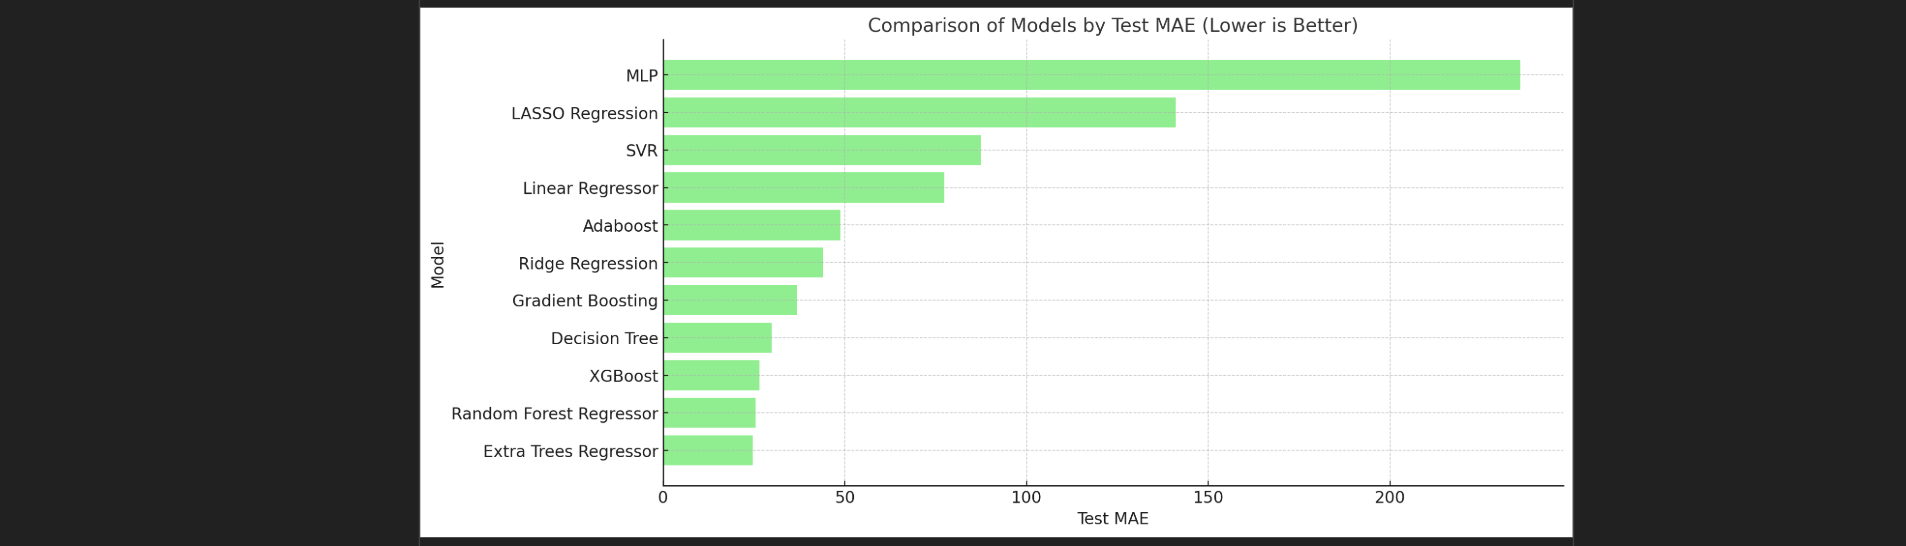

---
---

<br><br>


# **`Round 2:`** **`Model Training and Testing for Fit`** 
-  <h2><i>(Some Categorical features One-Hot Encoded and others Label Encoded)</i></h2>

In [23]:
## Preprocessor with OneHot Encoding and Label Encoding combined:
Preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Sector_Locality_Price_Density']),
        ## NO CHANGE: 'Bedrooms', 'Bathrooms', 'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score'
        ('cat1', OrdinalEncoder(), ['Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing']),
        ('cat2', OneHotEncoder(drop='first'), ['Flat', 'Sector_Locality', 'Locality'])
    ], remainder='passthrough'
)


## Checking all Model Performances with some categorical features OneHot and others Label Encoded:
summary2 = pd.DataFrame(model_scorer(model_dict, X, Y, Preprocessor2), 
                       columns = ['Model', 'CV R2 Mean', 'CV R2 STD', 
                                  'Test MAE', 'Test R2', 'Training MAE', 'Training R2'])
summary2

,Model,CV R2 Mean,CV R2 STD,Test MAE,Test R2,Training MAE,Training R2
0,Linear Regressor,0.906909,0.011749,37.116,0.8495,36.184,0.8468
1,SVR,0.910158,0.012416,40.710,0.7283,32.975,0.8229
2,Ridge Regression,0.907183,0.011969,36.255,0.8426,36.338,0.8812
3,LASSO Regression,-0.001578,0.001284,116.212,-0.0603,120.487,-0.0495
4,Decision Tree,0.916986,0.012419,28.400,0.9169,0.425,0.9998
5,Random Forest Regressor,0.949277,0.009746,26.341,0.8563,9.592,0.9684
6,Extra Trees Regressor,0.952347,0.009430,19.821,0.9334,0.400,0.9999
7,Gradient Boosting,0.923761,0.008597,37.942,0.7686,30.096,0.9041
8,Adaboost,0.856642,0.018170,51.524,0.9003,50.993,0.7929
9,MLP,0.911717,0.010779,34.127,0.8205,29.617,0.9287


### **`🔑 Key Observations from Performances Results` (OHE + Label vs. Only Label Encoding)**

### 1. **`Linear & Regularized Models`**

* **Linear & Ridge Regression** improved notably:

  * CV R² rose from ~0.889 to ~0.907.
  * Test R² improved from negative/unstable to **~0.84–0.85**.
  * MAE also dropped (from ~43–77 → ~36–37).
* This shows that **One-Hot Encoding helps linear models** capture non-linear effects of categorical variables (separating categories instead of imposing false numeric order).
* **LASSO Regression** still fails badly (negative Test R², very high MAE). The L1 penalty seems too aggressive for this dataset.


### 2. **`SVM & Neural Nets (MLP)`**

* **SVR** Test R² went from ~0.35 (earlier) → **0.73** now.

  * Huge improvement: OHE gave SVR the ability to differentiate categories properly.
* **MLP** also improved significantly:

  * Earlier Test R² was **negative (-0.60)**, now it’s **0.82**.
  * This confirms **neural models benefit a lot from OHE**, since they can’t interpret arbitrary label codes well.


### 3. **`Tree-Based Models`**

* **Decision Tree, Random Forest, Extra Trees, Gradient Boosting, XGBoost** → slight changes:

  * They were already strong with Label Encoding (since trees can split on integer codes).
  * Their performance remained roughly similar, sometimes slightly better (Extra Trees Test R² rose from 0.84 → **0.93**).
  * **XGBoost** surprisingly dropped a bit (from ~0.90 → **0.72** Test R²) → possible sensitivity to high-dimensional sparse OHE features.


### 4. **`Boosting Variants`**

* **Gradient Boosting** Test R² dropped (0.81 → **0.76**).
* **AdaBoost** improved a lot (0.60 → **0.90** Test R²).

  * Suggests AdaBoost was hurt by label encoding noise, but benefits from OHE.

---

### 5. **`General Trends`**
* **Linear family, SVR, and MLP → Big winners with OHE.**
* **Tree Ensembles → Stable regardless of encoding**, because they **can handle label codes well**.
* **XGBoost anomaly** → possibly struggling with OHE’s **expanded dimensionality** at defaults; **tuning may restore its edge**.

---

## 🎯 **`Implications for Next Steps`**

* For **linear, SVR, MLP** → definitely keep **One-Hot Encoding** for categorical features.
* For **tree ensembles (RF, Extra Trees, Gradient Boosting, XGBoost)** → **Label Encoding may be sufficient**, since OHE doesn’t provide consistent gains and sometimes hurts.
* Consider **Hybrid Encoding Strategy**:
  * Use OHE for categorical features with **low/moderate cardinality**.
  * Use **Target Encoding / Label Encoding** for **high-cardinality features**.

---

✅ **IN SHORT:**
* **OHE improved models** that **rely on distance/linear algebra** (Linear, Ridge, SVR, MLP).
* Tree ensembles remained strong either way, but **Extra Trees benefited**, while **XGBoost dipped**.
* This suggests moving forward with a **mixed encoding strategy** tuned per model type.

---
---

<br><br>


# **`Round 3:`** **`Model Training and Testing for Fit`** 
-  <h3><i>(Some Categorical features One-Hot Encoded, others Label Encoded and Sector_Locality (with 108 categories) as Target Encoded)</i></h3>

In [55]:
## Preprocessor with OneHot Encoding and Label Encoding combined:
Preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Sector_Locality_Price_Density']),
        ## NO CHANGE: 'Bedrooms', 'Bathrooms', 'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score'
        ('cat1', OrdinalEncoder(), ['Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing']),
        ('cat2', OneHotEncoder(drop='first'), ['Flat', 'Locality']),
        ('cat3', TargetEncoder(), ['Sector_Locality'])
    ], remainder='passthrough'
)


## Checking all Model Performances with some categorical features OneHot and others Label Encoded:
summary3 = pd.DataFrame(model_scorer(model_dict, X, Y, Preprocessor3), 
                       columns = ['Model', 'CV R2 Mean', 'CV R2 STD', 
                                  'Test MAE', 'Test R2', 'Training MAE', 'Training R2'])
summary3

,Model,CV R2 Mean,CV R2 STD,Test MAE,Test R2,Training MAE,Training R2
0,Linear Regressor,0.897822,0.015640,42.528,0.1097,41.015,0.4911
1,SVR,0.899295,0.013657,34.477,0.8458,38.498,0.6863
2,Ridge Regression,0.897895,0.015535,41.474,0.6954,39.951,0.5061
3,LASSO Regression,-0.001578,0.001284,114.501,-0.0808,121.223,-0.0496
4,Decision Tree,0.909753,0.010107,36.058,0.7693,4.794,0.9705
5,Random Forest Regressor,0.948394,0.009641,25.404,0.8889,11.920,0.9752
6,Extra Trees Regressor,0.952559,0.009180,27.098,0.8938,2.579,0.9977
7,Gradient Boosting,0.923469,0.008983,36.991,0.7030,29.828,0.9383
8,Adaboost,0.863388,0.017301,50.106,0.6618,48.808,0.8468
9,MLP,0.891202,0.015459,42.158,0.7917,39.771,0.8598


### **`🔑 Key Observations` (Label Only → OHE+Label → OHE+Label+Target Encoding)**

### 1. **`Linear Models (Linear & Ridge)`**
* Earlier (only Label encoding): **Test R² was negative or unstable** (≈ -24 to -0.49).
* With OHE: **improved strongly** to ~0.84–0.85.
* With OHE + Target Encoding: **performance collapsed again** (Test R² ≈ 0.10 for Linear, 0.69 for Ridge).
  + 👉 Interpretation: Linear models struggle with Target Encoded features because they treat the continuous target-encoded variable as numeric, which can mislead them. They benefited more from OHE.


### 2. **`LASSO Regression`**
* Consistently poor across all summaries (negative R², high MAE).
  + 👉 L1 regularization is too aggressive for this dataset.


### 3. **`SVR`**
* With Label encoding: weak (Test R² ~0.35).
* With OHE: big jump (Test R² ~0.72).
* With Target Encoding added: **even better (Test R² ~0.85)**.
  + 👉 SVR benefits from Target Encoding because it compresses a high-cardinality categorical feature into an informative numeric variable.


### 4. **`Tree-Based Models`**
* **Decision Tree**: Test R² steady (~0.76–0.86) across setups.
* **Random Forest, Extra Trees, XGBoost**:
  * Consistently top performers.
  * With Target Encoding, still strong (Test R² ~0.88–0.89).
  * Extra Trees remains highest (Test R² ~0.893).
    + 👉 These models are robust regardless of encoding, but Target Encoding did not harm them — results are stable.


### 5. **`Boosting Models`**
* **Gradient Boosting**: With OHE Test R² ~0.76, but with Target Encoding dropped to ~0.70.
* **AdaBoost**: With OHE jumped to ~0.90, but with Target Encoding dropped again to ~0.66.
  + 👉 Boosting models are sensitive to the nature of categorical encoding; Target Encoding might be introducing bias/leakage that hurts them without careful smoothing.


### 6. **`Neural Network (MLP)`**
* With OHE: Test R² ~0.82.
* With Target Encoding: still strong (Test R² ~0.79).
  + 👉 MLP remains competitive, but didn’t gain much from Target Encoding — OHE is more natural for neural nets.

---

## 📊 **`Overall Trend`**
* **Linear & Ridge**: Best with OHE only. Target Encoding hurts.
* **SVR**: Big beneficiary of Target Encoding → best so far (0.85 Test R²).
* **Tree Ensembles**: Strong across all setups. Consistently best performers, relatively unaffected by encoding changes.
* **Boosting models (GB, AdaBoost)**: Performed best with OHE, degraded with Target Encoding.
* **MLP**: Stable, but OHE suits it better.

---

## 🎯 **`Implications for Your Project`**
* Keep a **mixed strategy**:
  * **Low/medium cardinality categorical features → One Hot Encoding.**
  * **High cardinality feature → Target Encoding, but only for non-linear models like SVR or Tree Ensembles.**
  * **Avoid Target Encoding with Linear/Ridge unless carefully regularized.**
* Focus tuning on **Random Forest, Extra Trees, XGBoost, and SVR (with Target Encoding)** → these are your best candidates.

---
---

<br><br>

# **`III.` Let's Focus on tuning - **`Random Forest`**, **`Extra Trees`**, **`Gradient Boosting`** and **`XGBoost`** !**
- We'll use **Bayesian Optimization** to find the best set of Hyperparameters of these Models.
- Using **Optuna**.

## **`I.`** **Random Forest Regressor**

In [340]:
def make_pipeline_RF(model):
    ## Preprocessor with OHE, Label and Target Encoding combined:
    Preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Sector_Locality_Price_Density']),
            ## NO CHANGE: 'Bedrooms', 'Bathrooms', 'Covered_parking', 'Open_parking', 'Balcony', 
            ##            'Sector_Amenity_Score'
            ('cat1', OrdinalEncoder(), ['Age_Category', 'Floor_Category', 'Building_Height_Category', 
                                        'Furnishing']),
            ('cat2', OneHotEncoder(drop='first'), ['Flat', 'Locality']),
            ('cat3', TargetEncoder(), ['Sector_Locality'])
        ], remainder='passthrough'
    )
    
    # Creating a ML Pipeline:
    pipeline = Pipeline([
        ('Historial_PD_Feature_Adder', Sector_Locality_PD_Adder()),
        ('Preprocessor', Preprocessor),
        ('model', model)    
    ])

    return pipeline

In [87]:
import optuna  ## Library for Bayesian Optimization...

## Model:
model = RandomForestRegressor(n_jobs = -1)

## CV Strategy:
cv = KFold(n_splits=8, shuffle=True, random_state=42)

def objective_RF(trial):
    # hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 4, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5, 0.8, 0.1]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    pipe = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipe.set_params(model__n_estimators=params["n_estimators"],
                    model__max_depth=params["max_depth"],
                    model__min_samples_split=params["min_samples_split"],
                    model__min_samples_leaf=params["min_samples_leaf"],
                    model__max_features=params["max_features"],
                    model__bootstrap=params["bootstrap"])

    # Use R2 Score (higher is better for optuna)
    scores = cross_val_score(pipe, X, Y, scoring="r2", cv=cv, n_jobs=-1)
    
    # Return mean R2 Score (Optuna maximizes objective so return mean of scores)
    return scores.mean()  # cross_val_score returns R2 Score by above.

study = optuna.create_study(direction="maximize")  # maximize R2 Score
study.optimize(objective_RF, n_trials=40, timeout=None, n_jobs=1)

print("Best params:", study.best_params)
print("Best score (neg_rmse):", study.best_value)

[I 2025-09-29 17:16:29,508] A new study created in memory with name: no-name-300ae24f-e365-4e80-bd60-be701d5e615e
[I 2025-09-29 17:16:52,069] Trial 0 finished with value: 0.9317262843693181 and parameters: {'n_estimators': 147, 'max_depth': 18, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.8, 'bootstrap': True}. Best is trial 0 with value: 0.9317262843693181.
[I 2025-09-29 17:16:56,545] Trial 1 finished with value: 0.9217313390426894 and parameters: {'n_estimators': 148, 'max_depth': 23, 'min_samples_split': 22, 'min_samples_leaf': 18, 'max_features': 0.8, 'bootstrap': True}. Best is trial 0 with value: 0.9317262843693181.
[I 2025-09-29 17:16:59,096] Trial 2 finished with value: 0.9249259065846074 and parameters: {'n_estimators': 124, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.3, 'bootstrap': True}. Best is trial 0 with value: 0.9317262843693181.
[I 2025-09-29 17:17:01,549] Trial 3 finished with value: 0.899309234752466 and par

Best params: {'n_estimators': 424, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.3, 'bootstrap': False}
Best score (neg_rmse): 0.9485037928763099


<br>

## **Training Random Forest Regressor** with **Best set of Hyperparameter Values** obtained from Bayesian Optimization:

In [216]:
## 1st Set of Best Params:
Best_params1 = {'n_estimators': 210, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 
               'max_features': 0.5, 'bootstrap': False}        ## CV R2 Score: 0.952298

## 2nd Set of Best Params:
Best_params2 = {'n_estimators': 424, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 1, 
                'max_features': 0.3, 'bootstrap': False}       ## CV R2 Score: 0.948503

def train_and_stats(Best_params):
    ## Model:
    model = RandomForestRegressor(n_jobs = -1)

    pipeline = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipeline.set_params(model__n_estimators=Best_params["n_estimators"],
                        model__max_depth=Best_params["max_depth"],
                        model__min_samples_split=Best_params["min_samples_split"],
                        model__min_samples_leaf=Best_params["min_samples_leaf"],
                        model__max_features=Best_params["max_features"],
                        model__bootstrap=Best_params["bootstrap"])
    
    ## Splitting Data into Train-Test Sets:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.21125)
    
    ## Fitting the above Pipleine:
    pipeline.fit(X_train, Y_train)
    
    ## Predicting on Test Set:
    Y_pred = pipeline.predict(X_test)
    
    ## Scoring the Linear Regression Model:
    print("\t\t\t Random Forest Regressor performance with Best set of Hyperparameters:")
    print("MAE : ", mean_absolute_error(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Test R2 Score : ", r2_score(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Train R2 Score : ", r2_score(np.expm1(Y_train), np.expm1(pipeline.predict(X_train))))


train_and_stats(Best_params1)

			 Random Forest Regressor performance with Best set of Hyperparameters:
MAE :  2258511.572099648
Test R2 Score :  0.9270958315780179
Train R2 Score :  0.9747161891406173


### **`OBSERVATION :`** 
- **Random Forest Regressor looks stable and promising!**
- **Let's check other shortlisted Models.**

---

<br><br>
## **`II.`** **Extra Trees Regressor**

In [220]:
## Model:
model = ExtraTreesRegressor(n_jobs = -1)

def make_pipeline_RF(model):
    ## Preprocessor with OHE, Label and Target Encoding combined:
    Preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Sector_Locality_Price_Density']),
            ## NO CHANGE: 'Bedrooms', 'Bathrooms', 'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score'
            ('cat1', OrdinalEncoder(), ['Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing']),
            ('cat2', OneHotEncoder(drop='first'), ['Flat', 'Locality']),
            ('cat3', TargetEncoder(), ['Sector_Locality'])
        ], remainder='passthrough'
    )
    
    # Creating a ML Pipeline:
    pipeline = Pipeline([
        ('Historial_PD_Feature_Adder', Sector_Locality_PD_Adder()),
        ('Preprocessor', Preprocessor),
        ('model', model)    
    ])

    return pipeline


## CV Strategy:
cv = KFold(n_splits=8, shuffle=True, random_state=42)

def objective_RF(trial):
    # hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
        "max_depth": trial.suggest_int("max_depth", 4, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5, 0.8]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    pipe = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipe.set_params(model__n_estimators=params["n_estimators"],
                    model__max_depth=params["max_depth"],
                    model__criterion=params["criterion"],
                    model__min_samples_split=params["min_samples_split"],
                    model__min_samples_leaf=params["min_samples_leaf"],
                    model__max_features=params["max_features"],
                    model__bootstrap=params["bootstrap"])

    # Use R2 Score (higher is better for optuna)
    scores = cross_val_score(pipe, X, Y, scoring="r2", cv=cv, n_jobs=-1)
    
    # Return mean R2 Score (Optuna maximizes objective so return mean of scores)
    return scores.mean()  # cross_val_score returns R2 Score by above.

study = optuna.create_study(direction="maximize")  # maximize R2 Score
study.optimize(objective_RF, n_trials=50, timeout=None, n_jobs=1)

print("Best params:", study.best_params)
print("Best R2 Score:", study.best_value)

[I 2025-09-29 17:40:18,337] A new study created in memory with name: no-name-0376e396-eb08-4422-b604-5d00544f565a
[I 2025-09-29 17:40:30,987] Trial 0 finished with value: 0.8154217367120631 and parameters: {'n_estimators': 199, 'criterion': 'squared_error', 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8154217367120631.
[I 2025-09-29 17:40:36,086] Trial 1 finished with value: 0.8889083340601616 and parameters: {'n_estimators': 471, 'criterion': 'friedman_mse', 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 17, 'max_features': 0.5, 'bootstrap': True}. Best is trial 1 with value: 0.8889083340601616.
[I 2025-09-29 17:43:49,327] Trial 2 finished with value: 0.8407542651853316 and parameters: {'n_estimators': 266, 'criterion': 'absolute_error', 'max_depth': 11, 'min_samples_split': 23, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8

KeyboardInterrupt: 

<br>

## **Training Extra Trees Regressor** with **Best set of Hyperparameter Values** obtained from Bayesian Optimization:

In [239]:
## 1st Set of Best Params:
Best_params1 = {'n_estimators': 476, 'criterion': 'squared_error', 'max_depth': 17, 'min_samples_split': 3, 
                'min_samples_leaf': 1, 'max_features': 0.8, 'bootstrap': False}

def train_and_stats(Best_params):
    ## Model:
    model = ExtraTreesRegressor(n_jobs = -1)

    pipeline = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipeline.set_params(model__n_estimators=Best_params["n_estimators"],
                        model__max_depth=Best_params["max_depth"],
                        model__min_samples_split=Best_params["min_samples_split"],
                        model__min_samples_leaf=Best_params["min_samples_leaf"],
                        model__max_features=Best_params["max_features"],
                        model__bootstrap=Best_params["bootstrap"])
    
    ## Splitting Data into Train-Test Sets:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.21125)
    
    ## Fitting the above Pipleine:
    pipeline.fit(X_train, Y_train)
    
    ## Predicting on Test Set:
    Y_pred = pipeline.predict(X_test)
    
    ## Scoring the Linear Regression Model:
    print("\t\t\t Extra Trees Regressor performance with Best set of Hyperparameters:")
    print("MAE : ", mean_absolute_error(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Test R2 Score : ", r2_score(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Train R2 Score : ", r2_score(np.expm1(Y_train), np.expm1(pipeline.predict(X_train))))

train_and_stats(Best_params1)

			 Extra Trees Regressor performance with Best set of Hyperparameters:
MAE :  2311541.0029931264
Test R2 Score :  0.9225287536342799
Train R2 Score :  0.9802876862032781


### **`OBSERVATION :`** 
- **Extra Tree Regressor also looks stable and promising!**
- **Let's check last 2 Boosting Models.**

---

<br><br>
## **`III.`** **Gradient Boosting Regression**

In [245]:
## Model:
model = GradientBoostingRegressor()

def make_pipeline_RF(model):
    ## Preprocessor with OHE, Label and Target Encoding combined:
    Preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Sector_Locality_Price_Density']),
            ## NO CHANGE: 'Bedrooms', 'Bathrooms', 'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score'
            ('cat1', OrdinalEncoder(), ['Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing']),
            ('cat2', OneHotEncoder(drop='first'), ['Flat', 'Locality']),
            ('cat3', TargetEncoder(), ['Sector_Locality'])
        ], remainder='passthrough'
    )
    
    # Creating a ML Pipeline:
    pipeline = Pipeline([
        ('Historial_PD_Feature_Adder', Sector_Locality_PD_Adder()),
        ('Preprocessor', Preprocessor),
        ('model', model)    
    ])

    return pipeline


## CV Strategy:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective_RF(trial):
    # hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse"]),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5, 0.8]),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.4)
    }
    pipe = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipe.set_params(model__n_estimators=params["n_estimators"],
                    model__criterion=params["criterion"],
                    model__max_depth=params["max_depth"],
                    model__min_samples_split=params["min_samples_split"],
                    model__min_samples_leaf=params["min_samples_leaf"],
                    model__max_features=params["max_features"],
                    model__learning_rate=params["learning_rate"])

    # Use R2 Score (higher is better for optuna)
    scores = cross_val_score(pipe, X, Y, scoring="r2", cv=cv, n_jobs=-1)
    
    # Return mean R2 Score (Optuna maximizes objective so return mean of scores)
    return scores.mean()  # cross_val_score returns R2 Score by above.

study = optuna.create_study(direction="maximize")  # maximize R2 Score
study.optimize(objective_RF, n_trials=5, timeout=None, n_jobs=1)

print("Best params:", study.best_params)
print("Best R2 Score:", study.best_value)

[I 2025-09-29 19:28:53,661] A new study created in memory with name: no-name-35d6100a-d96a-4fe8-b28c-94e36b38688b
[I 2025-09-29 19:29:07,113] Trial 0 finished with value: 0.9443575115421551 and parameters: {'n_estimators': 192, 'criterion': 'squared_error', 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'learning_rate': 0.060004567507811885}. Best is trial 0 with value: 0.9443575115421551.
[I 2025-09-29 19:29:14,595] Trial 1 finished with value: 0.9386090320977143 and parameters: {'n_estimators': 205, 'criterion': 'squared_error', 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 12, 'max_features': 'log2', 'learning_rate': 0.25085498481611285}. Best is trial 0 with value: 0.9443575115421551.
[I 2025-09-29 19:29:22,534] Trial 2 finished with value: 0.9450811431952995 and parameters: {'n_estimators': 654, 'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_split': 22, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'learning_rate

Best params: {'n_estimators': 654, 'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_split': 22, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'learning_rate': 0.14418683175325256}
Best R2 Score: 0.9450811431952995


<br>

## **Training Gradient Boosting Regressor** with **Best set of Hyperparameter Values** obtained from Bayesian Optimization:

In [320]:
## Best Params from Bayesian Optimization:
Best_params1 = {'n_estimators': 654, 'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_split': 22, 
                'min_samples_leaf': 9, 'max_features': 'sqrt', 'learning_rate': 0.14418683175325256}  ## CV Mean R2 Score: 0.94508

## Some tweaks:
Best_params1 = {'n_estimators': 654, 'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_split': 45, 
                'min_samples_leaf': 9, 'max_features': 'sqrt', 'learning_rate': 0.14418683175325256}


def train_and_stats(Best_params):
    ## Model:
    model = GradientBoostingRegressor()

    pipeline = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipeline.set_params(model__n_estimators=Best_params["n_estimators"],
                    model__criterion=Best_params["criterion"],
                    model__max_depth=Best_params["max_depth"],
                    model__min_samples_split=Best_params["min_samples_split"],
                    model__min_samples_leaf=Best_params["min_samples_leaf"],
                    model__max_features=Best_params["max_features"],
                    model__learning_rate=Best_params["learning_rate"])
    
    ## Splitting Data into Train-Test Sets:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.21125)
    
    ## Fitting the above Pipleine:
    pipeline.fit(X_train, Y_train)
    
    ## Predicting on Test Set:
    Y_pred = pipeline.predict(X_test)
    
    ## Scoring the Linear Regression Model:
    print("\t\t\t Gradient Boosting Regressor performance with Best set of Hyperparameters:")
    print("MAE : ", mean_absolute_error(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Test R2 Score : ", r2_score(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Train R2 Score : ", r2_score(np.expm1(Y_train), np.expm1(pipeline.predict(X_train))))


train_and_stats(Best_params1)

			 Gradient Boosting Regressor performance with Best set of Hyperparameters:
MAE :  2357603.78139494
Test R2 Score :  0.9236608942788733
Train R2 Score :  0.9932667333470838


### **`OBSERVATION :`** 
- **Gradient Boosting Regressor looks robust, although it overfit the training data.**
- **Let's check last Boosting Model - XGBoost Regressor.**

---

<br><br>
## **`IV.`** **XGBoost Regression**

In [334]:
## Model:
model = XGBRegressor(n_jobs = -1)

def make_pipeline_RF(model):
    ## Preprocessor with OHE, Label and Target Encoding combined:
    Preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Sector_Locality_Price_Density']),
            ## NO CHANGE: 'Bedrooms', 'Bathrooms', 'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score'
            ('cat1', OrdinalEncoder(), ['Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing']),
            ('cat2', OneHotEncoder(drop='first'), ['Flat', 'Locality']),
            ('cat3', TargetEncoder(), ['Sector_Locality'])
        ], remainder='passthrough'
    )
    
    # Creating a ML Pipeline:
    pipeline = Pipeline([
        ('Historial_PD_Feature_Adder', Sector_Locality_PD_Adder()),
        ('Preprocessor', Preprocessor),
        ('model', model)    
    ])

    return pipeline


## CV Strategy:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective_RF(trial):
    # hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "tree_method": trial.suggest_categorical("tree_method", ["hist", "approx"]),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        #"max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5, 0.8]),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.4),
        "gama": trial.suggest_float("gama", 0, 100),  
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.5, 0.7, 0.8, 1]),
        "colsample_bylevel": trial.suggest_categorical("colsample_bylevel", [0.5, 0.7, 1]),
        "colsample_bynode": trial.suggest_categorical("colsample_bynode", [0.5, 0.7, 1])
    }
    pipe = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipe.set_params(model__n_estimators=params["n_estimators"],
                    model__tree_method=params["tree_method"],
                    model__max_depth=params["max_depth"],
                    model__min_samples_split=params["min_samples_split"],
                    model__min_samples_leaf=params["min_samples_leaf"],
                    #model__max_features=params["max_features"],
                    model__learning_rate=params["learning_rate"],
                    model__gama=params["gama"],
                    model__colsample_bytree=params["colsample_bytree"],
                    model__colsample_bylevel=params["colsample_bylevel"],
                    model__colsample_bynode=params["colsample_bynode"],
                   )

    # Use R2 Score (higher is better for optuna)
    scores = cross_val_score(pipe, X, Y, scoring="r2", cv=cv, n_jobs=-1)
    
    # Return mean R2 Score (Optuna maximizes objective so return mean of scores)
    return scores.mean()  # cross_val_score returns R2 Score by above.

study = optuna.create_study(direction="maximize")  # maximize R2 Score
study.optimize(objective_RF, n_trials=20, timeout=None, n_jobs=1)

print("Best params:", study.best_params)
print("Best R2 Score:", study.best_value)

[I 2025-09-29 19:48:07,991] A new study created in memory with name: no-name-01d5c9a5-d00b-40b9-acd0-39f5961c8925
[I 2025-09-29 19:48:08,699] Trial 0 finished with value: 0.9423691119455431 and parameters: {'n_estimators': 101, 'tree_method': 'hist', 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3, 'learning_rate': 0.06895643719677037, 'gama': 53.45952970089901, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'colsample_bynode': 1}. Best is trial 0 with value: 0.9423691119455431.
[I 2025-09-29 19:48:10,214] Trial 1 finished with value: 0.9437535719358581 and parameters: {'n_estimators': 774, 'tree_method': 'approx', 'max_depth': 4, 'min_samples_split': 24, 'min_samples_leaf': 6, 'learning_rate': 0.11833959929693275, 'gama': 30.271637457466525, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'colsample_bynode': 0.7}. Best is trial 1 with value: 0.9437535719358581.
[I 2025-09-29 19:48:20,422] Trial 2 finished with value: 0.9448225004650496 and parameters: {'n_estimators

Best params: {'n_estimators': 512, 'tree_method': 'approx', 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 11, 'learning_rate': 0.07200146859045528, 'gama': 4.8266464900444985, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'colsample_bynode': 1}
Best R2 Score: 0.9486951486402784


<br>

## **Training XGBoost Regressor** with **Best set of Hyperparameter Values** obtained from Bayesian Optimization:

In [117]:
## Best Params from Bayesian Optimization:
Best_params1 =  {'n_estimators': 374, 'tree_method': 'approx', 'max_depth': 11, 'min_samples_split': 30, 
                 'min_samples_leaf': 13, 'max_features': 'log2', 'learning_rate': 0.0686333147150158, 
                 'gama': 19.27371945501537, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.7} 
                ## CV Mean R2 Score: 0.9469383

Best_params1 =  {'n_estimators': 374, 'tree_method': 'auto', 'max_depth': 6, 'min_samples_split': 35, 
                 'min_samples_leaf': 20, 'max_features': 'log2', 'learning_rate': 0.15986333147150158, 
                 'gama': 24.27371945501537, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.7} 

Best_params2 = {'n_estimators': 512, 'tree_method': 'approx', 'max_depth': 25, 'min_samples_split': 2, 
                'min_samples_leaf': 11, 'learning_rate': 0.07200146859045528, 'gama': 4.8266464900444985, 
                'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'colsample_bynode': 1} 
                ## CV Mean R2 Score: 0.94869514

def make_pipeline_RF(model):
    ## Preprocessor with OHE, Label and Target Encoding combined:
    Preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Sector_Locality_Price_Density']),
            ## NO CHANGE: 'Bedrooms', 'Bathrooms', 'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score'
            ('cat1', OrdinalEncoder(), ['Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing']),
            ('cat2', OneHotEncoder(drop='first'), ['Flat', 'Locality']),
            ('cat3', TargetEncoder(), ['Sector_Locality'])
        ], remainder='passthrough'
    )
    
    # Creating a ML Pipeline:
    pipeline = Pipeline([
        ('Historial_PD_Feature_Adder', Sector_Locality_PD_Adder()),
        ('Preprocessor', Preprocessor),
        ('model', model)    
    ])

    return pipeline
    
def train_and_stats(params):
    ## Model:
    model = XGBRegressor(n_jobs=-1)

    pipeline = make_pipeline_RF(model)      ## Creating pipline with RFR Model....
    pipeline.set_params(model__n_estimators=params["n_estimators"],
                        model__tree_method=params["tree_method"],
                        model__max_depth=params["max_depth"],
                        model__min_samples_split=params["min_samples_split"],
                        model__min_samples_leaf=params["min_samples_leaf"],
                        #model__max_features=params["max_features"],
                        model__learning_rate=params["learning_rate"],
                        model__gama=params["gama"],
                        model__colsample_bytree=params["colsample_bytree"],
                        model__colsample_bylevel=params["colsample_bylevel"],
                        model__colsample_bynode=params["colsample_bynode"],
                       )
    
    ## Splitting Data into Train-Test Sets:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.21125)
    
    ## Fitting the above Pipleine:
    pipeline.fit(X_train, Y_train)
    
    ## Predicting on Test Set:
    Y_pred = pipeline.predict(X_test)
    
    ## Scoring the Linear Regression Model:
    print("\t\t\t XGBoost Regressor performance with Best set of Hyperparameters:")
    print("MAE : ", mean_absolute_error(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Test R2 Score : ", r2_score(np.expm1(Y_test), np.expm1(Y_pred)))
    print("Train R2 Score : ", r2_score(np.expm1(Y_train), np.expm1(pipeline.predict(X_train))))

    return pipeline

model_pipeline = train_and_stats(Best_params1)

			 XGBoost Regressor performance with Best set of Hyperparameters:
MAE :  3006695.9813208818
Test R2 Score :  0.9236739563025078
Train R2 Score :  0.978928175699816


### **`OBSERVATION :`** 
- **XGBoost Regressor looks robust, does not seem to overfit the training data.**
- **Is able to understand the underlying pattern in data, as Test R2 Score is also good and close to Training R2 Score.**
- **On comparison, XGBoost comes out to be a light solution with good generalisation of underlying data pattern.**
- Let's use it as Final Model for Price Prediction Engine.

---

<br>

# **`V.` Saving the XGBoost Regressor in Pickle File:**

In [402]:
import pickle

file_path = 'XGBoost_model_pipeline.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(model_pipeline, file)

print(f"Object saved to {file_path}")

Object saved to XGBoost_model_pipeline.pkl


---

<br><br>
# **Let's Final Check the Pickle File before Deployment:**

In [19]:
import pickle

## Custom Transformer Class for Adding new feature to Data:
class Sector_Locality_PD_Adder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.PD_records = None

    def fit(self, X, y=None):
        X = X.copy()   
        ## We are creating Historical Median Price Density Records from Property data: 
        self.PD_records = X.groupby(by = 'Sector_Locality').agg({'Avg_price_rupee_per_sqft': 'median'
                                                                  }).to_dict()['Avg_price_rupee_per_sqft']
        return self

    def transform(self, X):
        X = X.copy()   
        values = X['Sector_Locality'].replace(self.PD_records)   ## Using saved records...

        ## Creating a new feature with name "Sector_Locality_Price_Density" in X:
        X.insert(4, "Sector_Locality_Price_Density", values, allow_duplicates = False)
        
        ## Removing "Avg_price_rupee_per_sqft" from X as it can potentially cause Data Leakage:
        X = X[['Flat', 'Sector_Locality', 'Locality', 'Built_up_area_in_sqft', 'Sector_Locality_Price_Density', 
               'Age_Category', 'Floor_Category', 'Building_Height_Category', 'Furnishing', 'Bedrooms', 'Bathrooms', 
               'Covered_parking', 'Open_parking', 'Balcony', 'Sector_Amenity_Score']]
        
        return X


    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)


with open('XGBoost_model_pipeline.pkl', 'rb') as file:
    modelXGBR = pickle.load(file)

In [45]:
## Trying prediction for single record:
rec = pd.DataFrame(X_train.iloc[0]).T.drop(columns = ['Avg_price_rupee_per_sqft'])
np.expm1(modelXGBR.predict(rec))

array([17948552.], dtype=float32)

----